In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
import os

import warnings
warnings.filterwarnings('ignore')

In [135]:
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data\test.csv
data\train.csv


In [102]:
# data load
df = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Initial data exploration

In [3]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


We can see already that the numerical values look good. \
Other than Age, none of the entries are missing and max values seem to be in the realm of possibility with max Age being 80, max SibSp 8 and max Parch 6.\
With the mean value of 0.38 for Survived we can tell that most passangers didn't survive. \
Interestingly one or more of the passangers didn't pay for the voyage with min Fare being 0.\
Below we'll take a short look at some of the more interesting values.

In [4]:
# calculating mean ticket value, it is necessary since the mean value above is calculated not by ticket but by person and in reality multiple people board with one ticket
df[['Ticket', 'Fare']].groupby('Ticket').mean().sum() / 891

Fare    17.788989
dtype: float64

In [5]:
# total amount of money earned from passangers' fares
2224* 17.79

39564.96

In [6]:
# number of trips required to get 1500000 GBP
1500000/(2224* 17.79)

37.91233455057202

According to Wikipedia (https://en.wikipedia.org/wiki/Titanic) the cost of the Titanic was 1.5 million GBP.\
It would take 38 voyages for the Titanic to pay for itself. Note this doesn't include operational costs so the actual number would be much higher.

In [7]:
## passangers that didn't pay
df[df['Fare'] == 0.0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


In [8]:
df[df['Ticket'] == 'LINE']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S


According to encyclopedia-titanica (https://www.encyclopedia-titanica.org/titanic-victim/lionel-leonard.html?expand_article=1), the 4 above passangers were actually crewmates from a different ship that were forced to travel the Titanic due to a coal miners strike which caused their ship to stay in port. Their ticket number was actually 370160. It is suggsted that during the sinking they helped the crew in evacuation.

In [9]:
df[df['Fare'] == 0.0][df['Ticket'] != 'LINE']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S
674,675,0,2,"Watson, Mr. Ennis Hastings",male,NaN,0,0,239856,0.0,NaN,S
732,733,0,2,"Knight, Mr. Robert J",male,NaN,0,0,239855,0.0,NaN,S
806,807,0,1,"Andrews, Mr. Thomas Jr",male,39.0,0,0,112050,0.0,A36,S
815,816,0,1,"Fry, Mr. Richard",male,NaN,0,0,112058,0.0,B102,S


In [10]:
df_test[df_test['Name'].str.contains("Ismay")]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
372,1264,1,"Ismay, Mr. Joseph Bruce",male,49.0,0,0,112058,0.0,B52 B54 B56,S


Investigatig the first Name on the list Harrison, Mr. William (https://www.encyclopedia-titanica.org/titanic-victim/william-harrison.html?expand_article=1), we can read he embarked with his employer Ismay, Mr. Joseph Bruce\
According to wiki (https://en.wikipedia.org/wiki/J._Bruce_Ismay) Ismay was one of the creators of the Titanic, therefore it is understandeble why neither him or his employees paid.\
It is safe to assume those 0 values in Fare are correct.

Another interesting number is the highest number of siblings, being 8.

In [11]:
df[df['SibSp'] == 8]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [12]:
df_test[df_test['SibSp'] == 8]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
188,1080,3,"Sage, Miss. Ada",female,NaN,8,2,CA. 2343,69.55,NaN,S
360,1252,3,"Sage, Master. William Henry",male,14.5,8,2,CA. 2343,69.55,NaN,S


We can see that sadly none of the siblings in the train dataset survived, it will be interesting to see the result for the other two.

### Dealing with missing values

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [14]:
df.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [15]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Only 204 out of 891 passangers have a known cabin number. Other than that, as noted before some of the Age data is missing and 2 passangers don't have an Embarked value.\
We have to decide what to do with those missing entries.

In [16]:
df2 = df[['PassengerId', 'Survived', 'Cabin']]
df2['NumPas'] = 1
df2[['NumPas', 'Survived', 'Cabin']].groupby('Cabin').sum().sort_values('NumPas', ascending=False).head(10)

,NumPas,Survived
Cabin,,
C23 C25 C27,4,2
G6,4,2
B96 B98,4,4
F2,3,2
C22 C26,3,1
E101,3,3
F33,3,3
D,3,2
C78,2,1


In some cabins not every passanger survived

In [17]:
df[['Survived', 'Cabin']][df['Cabin'].isna() == False].groupby('Survived').count()

,Cabin
Survived,
0,68
1,136


We can see most of the people with cabin numbers survived

In [18]:
df[['Survived', 'Cabin']][df['Cabin'].isna()].fillna('Unknown').groupby('Survived').count()

,Cabin
Survived,
0,481
1,206


Meanwhile the majority without a known cabin number perished

Knowing that most of the people without cabin numbers perished, I will introduce a variable "CabinUnknown", which will be a binary value representing whether the passenger's cabin was known. The column Cabin with missing values will be dropped. I will also introduce a new dataframe named df_processed.

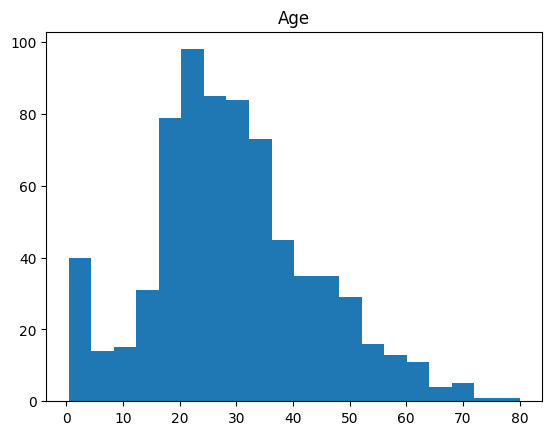

In [19]:
plt.hist(df['Age'], bins='auto')
plt.title('Age')
plt.show()

Since age data is in random order and the distribution looks natural with a lot of children I will fill the missing data in.

As for Embarked, only two values are missing, since the value is so low we can do external research.\
According to encylopedia-titanica both women boarded in Southampton.\
Amelia: https://www.encyclopedia-titanica.org/titanic-survivor/amelia-icard.html \
Martha: https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html

### Data processing

In [20]:
df_processed = df.copy() #copying original df to new variable
df_processed['Cabin_Unknown'] = [cabin for cabin in df['Cabin'].isna()] #adding a new feature
df_processed.drop(columns='Cabin', inplace=True) #dropping the Cabin feature

In [21]:
df_processed

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin_Unknown
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,False
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,False
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,True
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S,True
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S,False
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,S,True
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C,False


In [22]:
df_processed.isna().sum()

PassengerId        0
Survived           0
Pclass             0
Name               0
Sex                0
Age              177
SibSp              0
Parch              0
Ticket             0
Fare               0
Embarked           2
Cabin_Unknown      0
dtype: int64

In [23]:
df_processed['Age'].fillna(method='ffill', inplace=True) #forward filling missing age
df_processed['Embarked'].fillna(value='S', inplace=True) # filling missing Embarked with S for Southampton

In [24]:
df_processed.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         0
Cabin_Unknown    0
dtype: int64

In [25]:
# Transforming values with a Pipeline and Column Transformer
# Name and ticket will be dropped

binary_features = ['Sex', 'Cabin_Unknown']
categorical_features = ['Pclass', 'SibSp', 'Parch', 'Embarked']
numerical_features = ['Age', 'Fare']

binary_pipeline = Pipeline(steps=[
    ('scale', OneHotEncoder())
])
categorical_pipeline = Pipeline(steps=[
    ('scale', OrdinalEncoder())
])
numerical_pipeline = Pipeline(steps=[
    ('scale', MinMaxScaler())
])

processor = ColumnTransformer(transformers=[
    ('Number', numerical_pipeline, numerical_features),
    ('Categorical', categorical_pipeline, categorical_features),
    ('Binary', binary_pipeline, binary_features)
])

In [26]:
processor.fit(df_processed)

ColumnTransformer(transformers=[('Number',
                                 Pipeline(steps=[('scale', MinMaxScaler())]),
                                 ['Age', 'Fare']),
                                ('Categorical',
                                 Pipeline(steps=[('scale', OrdinalEncoder())]),
                                 ['Pclass', 'SibSp', 'Parch', 'Embarked']),
                                ('Binary',
                                 Pipeline(steps=[('scale', OneHotEncoder())]),
                                 ['Sex', 'Cabin_Unknown'])])

In [27]:
X = pd.DataFrame(processor.transform(df_processed), columns = processor.get_feature_names_out())
y = df_processed['Survived'].to_numpy()
X

,Number__Age,Number__Fare,Categorical__Pclass,Categorical__SibSp,Categorical__Parch,Categorical__Embarked,Binary__Sex_female,Binary__Sex_male,Binary__Cabin_Unknown_False,Binary__Cabin_Unknown_True
0,0.271174,0.014151,2.0,1.0,0.0,2.0,0.0,1.0,0.0,1.0
1,0.472229,0.139136,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.321438,0.015469,2.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0
3,0.434531,0.103644,0.0,1.0,0.0,2.0,1.0,0.0,1.0,0.0
4,0.434531,0.015713,2.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
886,0.334004,0.025374,1.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0
887,0.233476,0.058556,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0
888,0.233476,0.045771,2.0,1.0,2.0,2.0,1.0,0.0,0.0,1.0
889,0.321438,0.058556,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [28]:
X = X.to_numpy().reshape(-1,len(X.columns))
X

array([[0.27117366, 0.01415106, 2.        , ..., 1.        , 0.        ,
        1.        ],
       [0.4722292 , 0.13913574, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.32143755, 0.01546857, 2.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.23347575, 0.04577135, 2.        , ..., 0.        , 0.        ,
        1.        ],
       [0.32143755, 0.0585561 , 0.        , ..., 1.        , 1.        ,
        0.        ],
       [0.39683338, 0.01512699, 2.        , ..., 1.        , 0.        ,
        1.        ]])

In [29]:
y

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Model Selection

In [49]:
model_1 = RandomForestClassifier()
model_1.fit(X_train, y_train)
y_pred = model_1.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       137
           1       0.78      0.78      0.78        86

    accuracy                           0.83       223
   macro avg       0.82      0.82      0.82       223
weighted avg       0.83      0.83      0.83       223



In [50]:
model_2 = xgb.XGBClassifier()
model_2.fit(X_train, y_train)
y_pred = model_2.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       137
           1       0.78      0.77      0.77        86

    accuracy                           0.83       223
   macro avg       0.82      0.81      0.82       223
weighted avg       0.82      0.83      0.82       223



In [52]:
model_3 = SVC()
model_3.fit(X_train, y_train)
y_pred = model_3.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       137
           1       0.81      0.74      0.78        86

    accuracy                           0.83       223
   macro avg       0.83      0.82      0.82       223
weighted avg       0.83      0.83      0.83       223



In [64]:
xgb_grid = xgb.XGBClassifier()
learning_rate = np.linspace(0.01, 0.1, 5)
n_estimators = np.arange(100, 2501, 100)
param_grid = dict(n_estimators=n_estimators,
                  learning_rate=learning_rate)
kfold = StratifiedKFold(n_splits=10, shuffle=True)

grid_search_xgb = GridSearchCV(xgb_grid, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=kfold)
grid_result_xgb = grid_search_xgb.fit(X_train, y_train)

print(grid_result_xgb.best_score_, grid_result_xgb.best_params_)

0.8548181005985885 {'learning_rate': 0.01, 'n_estimators': 200}


In [94]:
model_xgb = xgb.XGBClassifier(eta=0.01, n_estimators= 200)
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       137
           1       0.84      0.74      0.79        86

    accuracy                           0.85       223
   macro avg       0.85      0.83      0.84       223
weighted avg       0.85      0.85      0.85       223



In [67]:
param_grid = {'C': [0.01, 0.001, 0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid_search_svm = GridSearchCV(SVC(), param_grid, refit = True) 
  
 
grid_results_svm = grid_search_svm.fit(X_train, y_train) 
print(grid_results_svm.best_score_, grid_results_svm.best_params_)


0.7964987094602177 {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}


In [68]:
model_svm = SVC(C = 0.1, gamma=0.1, kernel='rbf')
model_svm.fit(X_train, y_train)
y_pred = model_svm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       137
           1       0.79      0.74      0.77        86

    accuracy                           0.83       223
   macro avg       0.82      0.81      0.81       223
weighted avg       0.82      0.83      0.82       223



XGB will be used for prediction

### Calculating prediction for the test dataset

In [103]:
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [104]:
df_test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [105]:
# filling in missing data for Age and Fare
df_test_processed = df_test.copy()
df_test_processed['Age'].fillna(method='ffill', inplace=True)
df_test_processed['Fare'].fillna(method='ffill', inplace=True)

In [106]:
df_test_processed.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64

In [107]:
# Adding an additional column for Cabin data a dropping cabins
df_test_processed['Cabin_Unknown'] = [cabin for cabin in df_test['Cabin'].isna()]
df_test_processed.drop(columns='Cabin', inplace=True)

In [108]:
df_test_processed

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin_Unknown
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,True
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,True
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,True
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,True
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,True
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,28.0,0,0,A.5. 3236,8.0500,S,True
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C,False
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S,True
416,1308,3,"Ware, Mr. Frederick",male,38.5,0,0,359309,8.0500,S,True


In [109]:
processor.fit(df_test_processed)

ColumnTransformer(transformers=[('Number',
                                 Pipeline(steps=[('scale', MinMaxScaler())]),
                                 ['Age', 'Fare']),
                                ('Categorical',
                                 Pipeline(steps=[('scale', OrdinalEncoder())]),
                                 ['Pclass', 'SibSp', 'Parch', 'Embarked']),
                                ('Binary',
                                 Pipeline(steps=[('scale', OneHotEncoder())]),
                                 ['Sex', 'Cabin_Unknown'])])

In [110]:
X = pd.DataFrame(processor.transform(df_test_processed), columns = processor.get_feature_names_out())

In [111]:
X

,Number__Age,Number__Fare,Categorical__Pclass,Categorical__SibSp,Categorical__Parch,Categorical__Embarked,Binary__Sex_female,Binary__Sex_male,Binary__Cabin_Unknown_False,Binary__Cabin_Unknown_True
0,0.452723,0.015282,2.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1,0.617566,0.013663,2.0,1.0,0.0,2.0,1.0,0.0,0.0,1.0
2,0.815377,0.018909,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,0.353818,0.016908,2.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0
4,0.287881,0.023984,2.0,1.0,1.0,2.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
413,0.367005,0.015713,2.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0
414,0.512066,0.212559,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
415,0.505473,0.014151,2.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0
416,0.505473,0.015713,2.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0


In [112]:
y_predicted = model_xgb.predict(X)

In [113]:
y_predicted

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [114]:
df_test['Prediciton'] = y_predicted

In [115]:
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Prediciton
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,0


In [116]:
df_test[df_test['SibSp'] == 8]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Prediciton
188,1080,3,"Sage, Miss. Ada",female,NaN,8,2,CA. 2343,69.55,NaN,S,0
360,1252,3,"Sage, Master. William Henry",male,14.5,8,2,CA. 2343,69.55,NaN,S,0


As we can see it is predicted that the entire Sage family perished

In [137]:
output = pd.DataFrame({'PassengerId': df_test.PassengerId, 'Survived': df_test.Prediciton})

In [140]:
output.to_csv('output/submission.csv', index=False)